In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
pd.options.display.float_format = '{:.5f}'.format
bus_bts = pd.read_csv("bus_bts.csv")
train = pd.read_csv("train.csv")
submission = pd.read_csv("submission_sample.csv")
rain = pd.read_csv("rain.csv",encoding='euc-kr')

In [2]:
rain.columns = ['지점', '지점명', '일시', '강수량', 'QC']

In [3]:
#오류인 관측치를 0으로 대체
rain2 = rain.fillna(0)

In [4]:
#일시를 기준으로 정렬
rain2 = rain2.sort_values(by='일시')
rain2 = rain2.reset_index()

In [5]:
#6시~12시 관측값만 남기기
rain2 = rain2[rain2['일시'].str.contains('07:|08:|09:|10:|11:|12:')]

In [6]:
#동시간 네지역 강수량을 합치기
for i in range (0,len(rain2)-1) :
    if (rain2.iloc[i,3] == rain2.iloc[i+1, 3]) :
        rain2.iloc[i+1,4] += rain2.iloc[i,4]
        
rain2 = rain2.drop_duplicates(['일시'])

In [7]:
#6시~12시 강수량을 일별로 모두 합치기
day_rain = rain2
for i in range (0,len(day_rain)-1) :
    if i%6==5 :
        continue
    else :
        day_rain.iloc[i+1,4] += day_rain.iloc[i,4]
        
day_rain = day_rain.reset_index()
day_rain = day_rain.drop(['index'],axis=1)

for i in range(0,len(day_rain)-1) :
    if i%6==5:
        continue
    else:
        day_rain = day_rain.drop(index=i,axis=0)

day_rain = day_rain.reset_index()

In [8]:
day_rain["일시"] = pd.to_datetime(day_rain.일시,format='%Y-%m-%d %H:%M')
day_rain["일시"]= day_rain["일시"].dt.date
day_rain = day_rain.drop(['index','level_0','지점명','지점','QC'], axis=1)
day_rain

,일시,강수량
0,2019-09-01,0.00000
1,2019-09-02,15.30000
2,2019-09-03,6.40000
3,2019-09-04,80.60000
4,2019-09-05,1.70000
5,2019-09-06,2.10000
6,2019-09-07,0.00000
7,2019-09-08,0.30000
8,2019-09-09,10.20000
9,2019-09-11,0.00000


In [9]:
#비 안옴(0), 약한 비(1), 강한 비(2) 로 구분
rain_class = []

for i in range (len(day_rain)):
    if (day_rain.iloc[i,1] == 0):
        rain_class.append(0)
    elif (day_rain.iloc[i,1] <= 18) :
        rain_class.append(1)
    elif (day_rain.iloc[i,1] > 18):
        rain_class.append(2)

day_rain["강수 정도"] = rain_class

In [10]:
day_rain

,일시,강수량,강수 정도
0,2019-09-01,0.00000,0
1,2019-09-02,15.30000,1
2,2019-09-03,6.40000,1
3,2019-09-04,80.60000,2
4,2019-09-05,1.70000,1
5,2019-09-06,2.10000,1
6,2019-09-07,0.00000,0
7,2019-09-08,0.30000,1
8,2019-09-09,10.20000,1
9,2019-09-11,0.00000,0


In [11]:
#데이터셋을 만들때 강수량이 결측치인 날을 빼고 만들자 ...
train2 = train.drop(['id','bus_route_id','in_out','station_code','station_name','latitude','longitude'],axis=1)
r67 = train2.groupby("date")["6~7_ride"].sum()
r78 = train2.groupby("date")["7~8_ride"].sum()
r89 = train2.groupby("date")["8~9_ride"].sum()
r910 = train2.groupby("date")["9~10_ride"].sum()
r1011 = train2.groupby("date")["10~11_ride"].sum()
r1112 = train2.groupby("date")["11~12_ride"].sum()
t67 = train2.groupby("date")["6~7_takeoff"].sum()
t78 = train2.groupby("date")["7~8_takeoff"].sum()
t89 = train2.groupby("date")["8~9_takeoff"].sum()
t910 = train2.groupby("date")["9~10_takeoff"].sum()
t1011 = train2.groupby("date")["10~11_takeoff"].sum()
t1112 = train2.groupby("date")["11~12_takeoff"].sum()
pd.DataFrame(r67)
pd.DataFrame(r78)
pd.DataFrame(r89)
pd.DataFrame(r910)
pd.DataFrame(r1011)
pd.DataFrame(r1112)
pd.DataFrame(t67)
pd.DataFrame(t78)
pd.DataFrame(t89)
pd.DataFrame(t910)
pd.DataFrame(t1011)
pd.DataFrame(t1112)
train3 = pd.concat([r67,r78,r89,r910,r1011,r1112,t67,t78,t89,t910,t1011,t1112],axis=1)

day_ride = pd.DataFrame(train3.iloc[:,0:6].sum(axis=1))
day_ride = day_ride.reset_index()
day_ride = day_ride[~day_ride['date'].str.contains('10|13|14|15|17|18|-19|2019-09-20|24|25|28',na=False)]
day_ride = day_ride.reset_index()
day_ride = day_ride.drop('index',axis=1)

day_ride.columns = ['일시','탑승자수']

In [12]:
day_ride

,일시,탑승자수
0,2019-09-01,32922.00000
1,2019-09-02,59176.00000
2,2019-09-03,63864.00000
3,2019-09-04,57057.00000
4,2019-09-05,66328.00000
5,2019-09-06,60228.00000
6,2019-09-07,26086.00000
7,2019-09-08,31807.00000
8,2019-09-09,62503.00000
9,2019-09-11,65431.00000


In [13]:
train

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.00000,1.00000,...,5.00000,2.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.00000,4.00000,...,2.00000,5.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.00000,1.00000,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.00000,17.00000,...,26.00000,14.00000,16.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,53.00000
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,32820000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415419,415419,2019-09-30,32820000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415420,415420,2019-09-30,32820000,시내,2322,해병부대,33.23100,126.26273,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415421,415421,2019-09-30,32820000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [15]:
train.bus_route_id = train.bus_route_id * 0.0001

2346.0
2803.0
3003.0


In [16]:
print(train.bus_route_id.quantile(0))
print(train.bus_route_id.quantile(0.25))
print(train.bus_route_id.quantile(0.5))
print(train.bus_route_id.quantile(0.75))
print(train.bus_route_id.quantile(1))

427.0
2346.0
2803.0
3003.0
3282.0


In [20]:
bus_id = train.bus_route_id
bus_id = bus_id.drop_duplicates()

In [19]:
color = []
for i in range (len(train.bus_route_id)) :
    if (train.iloc[i,2] < 2000) :
        color.append("red")
    elif (train.iloc[i,2] < 2100) :
        color.append("orange")
    elif (train.iloc[i,2] < 2200) :
        color.append("yellow")
    elif (train.iloc[i,2] < 2300) :
        color.append("green")
    elif (train.iloc[i,2] < 2400) :
        color.append("blue")
    elif (train.iloc[i,2] < 2500) :
        color.append("purple")
    elif (train.iloc[i,2] < 2600) :
        color.append("brown")
    elif (train.iloc[i,2] < 2700) :
        color.append("pink")
    elif (train.iloc[i,2] < 2800) :
        color.append("gray")
    elif (train.iloc[i,2] < 2900) :
        color.append("cyan")
    elif (train.iloc[i,2] < 3000) :
        color.append("olive")
    elif (train.iloc[i,2] < 3100) :
        color.append("thistle")

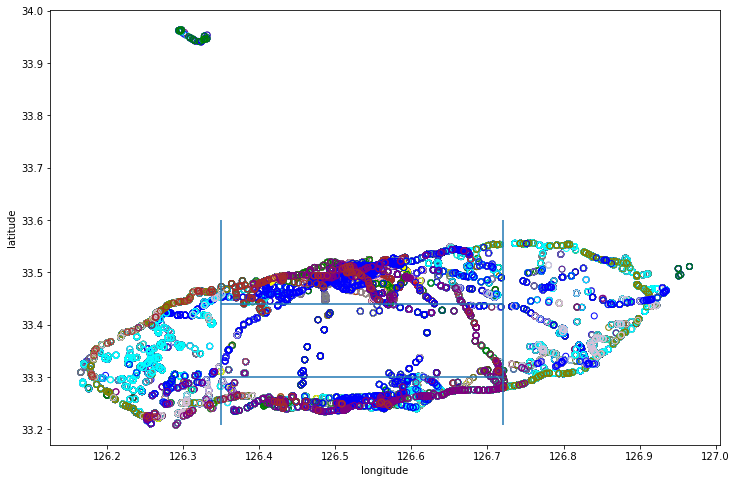

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

ax.scatter(train.longitude, train.latitude, color=color, facecolor="none")

plt.vlines(126.35, min(train["latitude"]), 33.6)
plt.vlines(126.72, min(train["latitude"]), 33.6)
plt.hlines(33.44, 126.35, 126.72)
plt.hlines(33.3, 126.35, 126.72)

plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

In [38]:
mount = []
for i in range(len(train.latitude)) :
    if ((126.35 < train.iloc[i,7] < 126.72) & (33.3 < train.iloc[i,6] < 33.44)) :
        mount.append(1)
    else :
        mount.append(0)

In [43]:
mount = pd.DataFrame(mount)
train = pd.concat([mount,train],axis=1)

In [44]:
train

,0,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,0,2019-09-01,427.00000,시외,344,제주썬호텔,33.48990,126.49373,0.00000,...,5.00000,2.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,0,1,2019-09-01,427.00000,시외,357,한라병원,33.48944,126.48508,1.00000,...,2.00000,5.00000,6.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000
2,0,2,2019-09-01,427.00000,시외,432,정존마을,33.48181,126.47352,1.00000,...,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000
3,0,3,2019-09-01,427.00000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.00000,...,26.00000,14.00000,16.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,53.00000
4,0,4,2019-09-01,427.00000,시내,1646,중문관광단지입구,33.25579,126.41260,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,0,415418,2019-09-30,3282.00000,시내,1129,한림환승정류장(한림리),33.41437,126.26336,4.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415419,0,415419,2019-09-30,3282.00000,시내,1564,제주시외버스터미널,33.49946,126.51479,4.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415420,0,415420,2019-09-30,3282.00000,시내,2322,해병부대,33.23100,126.26273,0.00000,...,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
415421,0,415421,2019-09-30,3282.00000,시내,3291,애월환승정류장(애월리),33.46483,126.31870,1.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
